In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### 一、載入資料

1.1. 載入資料

In [2]:
data = pd.read_csv('/Users/yitsung/git/MastersThesis/data/TaiwanStockData_Top100_EMA')
ticker_2330 = data[data['ticker']==2330].reset_index(drop=True)
ticker_2330 = ticker_2330.drop(columns=['ticker'])
ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
704,2023-11-27,573.0,577.0,568.0,568.0,20322.0,-112.0,-2153.0,59.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
705,2023-11-28,565.0,576.0,565.0,575.0,26932.0,478.0,3323.0,-98.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
706,2023-11-29,578.0,579.0,570.0,574.0,27787.0,357.0,-180.0,55.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
707,2023-11-30,576.0,577.0,570.0,577.0,54365.0,-32.0,4730.0,-68.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
708,2023-12-01,573.0,579.0,573.0,579.0,28798.0,-260.0,7120.0,-611.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.2.轉換成EMA+return data

In [3]:
# 取differ
feature_to_differ = ['financing', 'fi', 'ii']
ticker_2330[feature_to_differ] = ticker_2330[feature_to_differ].diff()

# origi_data
origi_data = ticker_2330.copy() # 用來之後還原答案的

# 把價格變成報酬率
ticker_2330['open'] = (ticker_2330['open'] - ticker_2330['open'].shift(1)) / ticker_2330['open'].shift(1)
ticker_2330['high'] = (ticker_2330['high'] - ticker_2330['high'].shift(1)) / ticker_2330['high'].shift(1)
ticker_2330['low'] = (ticker_2330['low'] - ticker_2330['low'].shift(1)) / ticker_2330['low'].shift(1)
ticker_2330['close'] = (ticker_2330['close'] - ticker_2330['close'].shift(1)) / ticker_2330['close'].shift(1)

ticker_2330.replace([float('inf'), -float('inf')], 0, inplace=True) # 不知道為何有些調整過後會變inf, 要拿掉(應該是連兩天的價格都相同)
ticker_2330 = ticker_2330.dropna().reset_index(drop=True)

ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
703,2023-11-27,-0.006932,-0.001730,-0.010453,-0.012174,20322.0,-355.0,-1299.0,-11.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
704,2023-11-28,-0.013962,-0.001733,-0.005282,0.012324,26932.0,590.0,5476.0,-157.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
705,2023-11-29,0.023009,0.005208,0.008850,-0.001739,27787.0,-121.0,-3503.0,153.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
706,2023-11-30,-0.003460,-0.003454,0.000000,0.005226,54365.0,-389.0,4910.0,-123.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
707,2023-12-01,-0.005208,0.003466,0.005263,0.003466,28798.0,-228.0,2390.0,-543.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.3.切Library和Prediction

In [4]:
Library = ticker_2330[ticker_2330['Date'] < '2023-07-01']
Prediction = ticker_2330[ticker_2330['Date'] >= '2023-07-01']
Prediction

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
602,2023-07-03,0.014035,0.006944,0.014085,0.005208,15118.0,-20.0,4926.0,-39042.0,1401.0,582.0,2.5477,576.701182,575.940219,566.756798,9.183421,11.833896,33.311646
603,2023-07-04,0.012111,0.008621,0.006944,0.010363,17777.0,-13.0,2452.0,-1043.0,-13.0,1767.0,2.7068,578.360946,577.334031,568.108146,9.225886,11.312294,30.627646
604,2023-07-05,0.006838,0.006838,-0.001724,-0.005128,15554.0,-134.0,-5695.0,845.0,-1092.0,-790.0,2.6473,579.088757,578.051873,569.137172,8.914701,10.832775,17.707207
605,2023-07-06,-0.027165,-0.025467,-0.024180,-0.029210,32070.0,613.0,-15586.0,-71.0,-603.0,-14045.0,5.1447,576.271005,576.043892,568.830715,7.213177,10.108856,7.697299
606,2023-07-07,-0.013962,-0.003484,-0.003540,0.000000,19859.0,-531.0,11990.0,389.0,-100.0,-1681.0,3.6264,574.016804,574.344832,568.546958,5.797874,9.246659,1.662877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,2023-11-27,-0.006932,-0.001730,-0.010453,-0.012174,20322.0,-355.0,-1299.0,-11.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
704,2023-11-28,-0.013962,-0.001733,-0.005282,0.012324,26932.0,590.0,5476.0,-157.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
705,2023-11-29,0.023009,0.005208,0.008850,-0.001739,27787.0,-121.0,-3503.0,153.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
706,2023-11-30,-0.003460,-0.003454,0.000000,0.005226,54365.0,-389.0,4910.0,-123.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342


### 二、資料分拆

In [5]:
### Train data ###

# 製作df
Library['ans'] = Library['close'].shift(-1) # 預測Tp=1
Library_ = Library.dropna().set_index('Date')
# Library_ = Library_.drop('close') # 選擇性

# 標準化
scaler_train = MinMaxScaler()
Library_train = scaler_train.fit_transform(Library_)

# 分拆X和y
X = Library_train[:, :-1]
y = Library_train[:, -1]

# 輸出成array
X, y = np.array(X), y.reshape(-1, 1)


In [6]:
### Valid data ###

# 製作df
Prediction['ans'] = Prediction['close'].shift(-1) # 預測Tp=1
Prediction_ = Prediction.dropna().set_index('Date')
Prediction_ = Prediction_.drop('close') # 選擇性

# 分拆X和y
X_pred = Prediction_.iloc[:, :-1]
y_ans = Prediction_.iloc[:, -1]
y_ans = np.array(y_ans).reshape(-1, 1) # 先變成array

# 標準化
scaler = MinMaxScaler()
X_pred = scaler.fit_transform(X_pred)
scaler_y = MinMaxScaler()
scalered_y_ans = scaler_y.fit_transform(y_ans)


KeyError: "['close'] not found in axis"

### 三、建模分析

3.1. 建構XGBR model

In [ ]:
# parameters = {'n_estimators':range(10, 300, 10),
#               'max_depth':range(2,10,1),
#               'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
#               'min_child_weight':range(5, 21, 1),
#               'subsample':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
#               'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
#               'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
#               'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1]
#              }

# model = XGBRegressor(seed=87, # model_seed
#                      n_estimators=100,
#                      max_depth=3,
#                      eval_metric='rmse',
#                      learning_rate=0.1,
#                      min_child_weight=1,
#                      subsample=1,
#                      colsample_bytree=1,
#                      colsample_bylevel=1,
#                      gamma=0)

In [ ]:
def train_XGBR_model(parameters, X, y):

    val_fold = [-1] * int(len(X)*0.8) + [0] * int(len(X)*0.2) # 後20%用來validation
    ps = PredefinedSplit(test_fold=val_fold)

    model = XGBRegressor()
    XGBR_model = GridSearchCV(estimator=model, param_grid=parameters, cv=ps, 
                              refit=True, scoring='neg_mean_squared_error')

    XGBR_model.fit(X,y)
    print('最佳參數: ', XGBR_model.best_params_)

    return XGBR_model

parameters = {'n_estimators':range(100, 1000, 100),
              'max_depth':range(2,10,2),
              'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5]}

XGBR_model = train_XGBR_model(parameters=parameters, X=X, y=y)
# 最佳參數:  {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 100}

最佳參數:  {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 100}


3.2. 進行預測並檢視結果

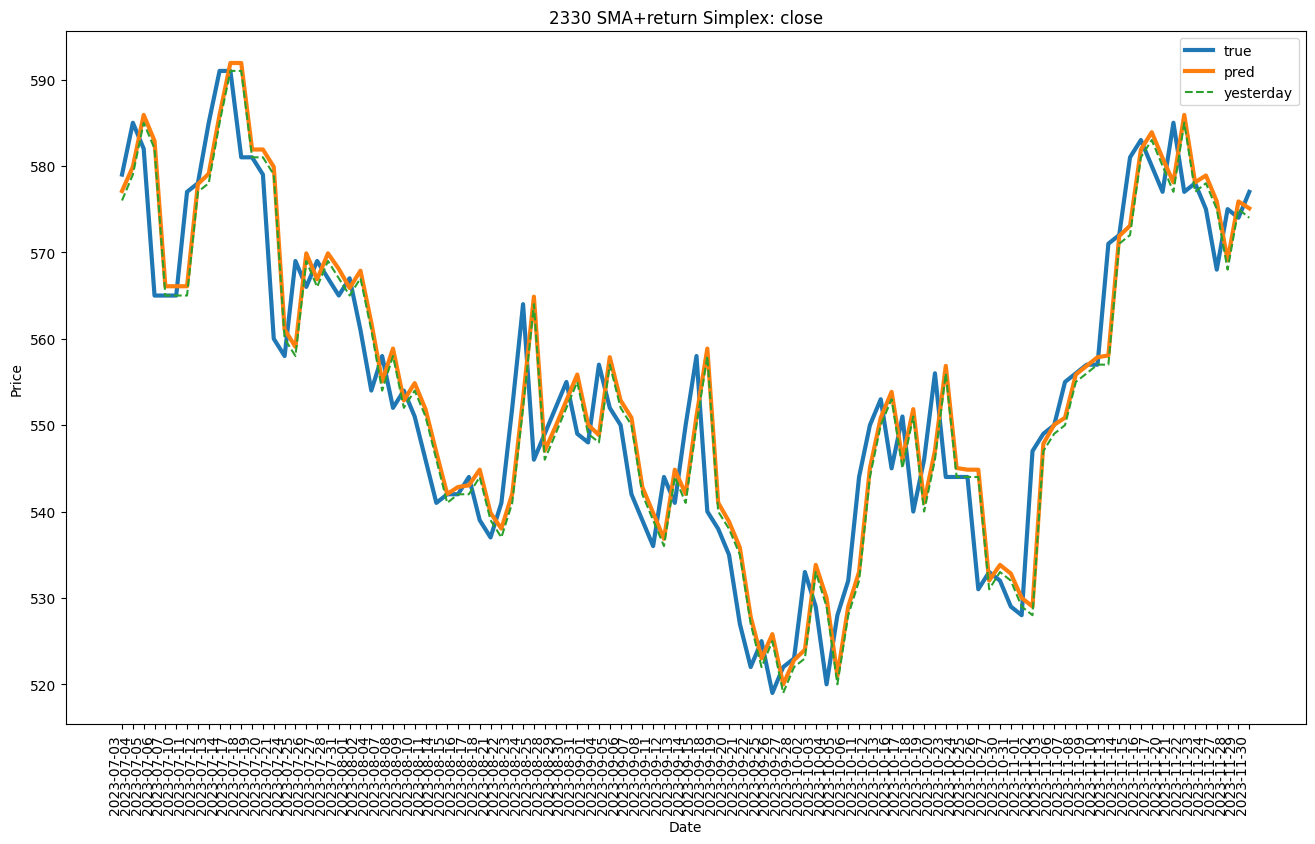

In [ ]:
def predict_valuation(XGBR_model, X_pred, y_ans, scaler_y, origi_data):

    ### 預測 ###
    y_pred = XGBR_model.predict(X_pred)
    y_pred = y_pred.reshape(-1,1) # reshape成可以還原的格式
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = pd.Series(y_pred.reshape(-1)) # 變成series格式化成相同index方便畫圖

    # 取得前一日資料
    yesterday = origi_data[(origi_data['Date']>='2023-06-30') & (origi_data['Date']<'2023-11-30')].reset_index(drop=True)
    # 取得今日資料
    Today = origi_data[(origi_data['Date']>='2023-07-01') & (origi_data['Date']<'2023-12-01')].reset_index(drop=True)
    # Date
    Date = origi_data[(origi_data['Date']>='2023-07-01') & (origi_data['Date']<'2023-12-01')].reset_index()

    # 製作還原預測資料
    XGBR_result = pd.DataFrame(yesterday['close'])
    XGBR_result = XGBR_result.rename(columns={'close': 'Yesterday'})
    XGBR_result['Predictions'] = XGBR_result['Yesterday'] * (1+y_pred)
    XGBR_result['Observations'] = Today['close']   
    XGBR_result['Date'] = Date['Date']

    XGBR = XGBR_result[['Date', 'Observations', 'Predictions', 'Yesterday']]

    # 繪圖
    plt.figure(figsize=(16, 9))
    plt.plot(XGBR['Date'], XGBR[f'Observations'], linewidth=3, label='true')
    plt.plot(XGBR['Date'], XGBR[f'Predictions'], linewidth=3, label='pred')
    plt.plot(XGBR['Date'], XGBR[f'Yesterday'], linestyle='--', label='yesterday')

    plt.xlabel('Date')
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Price')
    plt.title(f'2330 EMA+return XGBR: close')
    plt.legend()
    plt.show()

    return XGBR

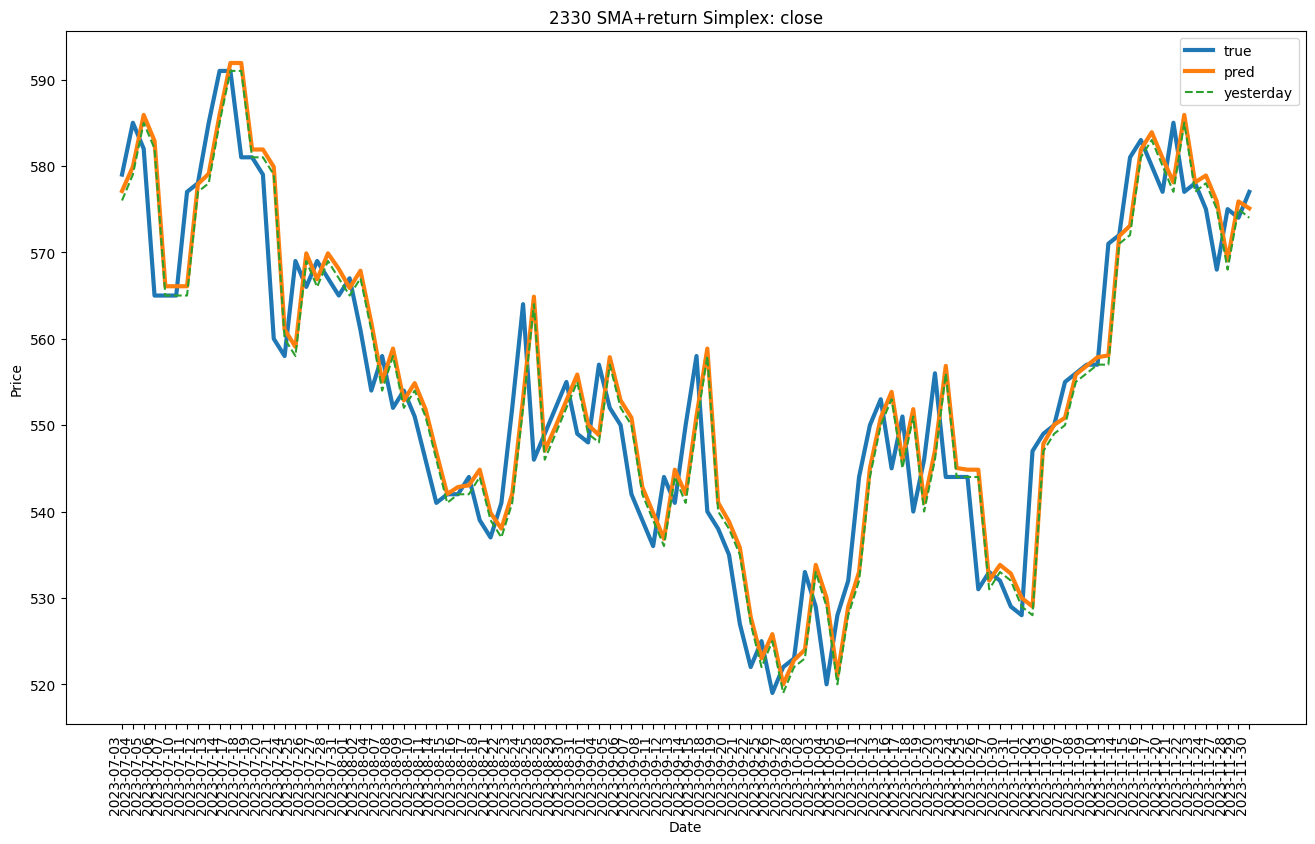

,Date,Observations,Predictions,Yesterday
0,2023-07-03,579.0,577.096710,576.0
1,2023-07-04,585.0,579.899635,579.0
2,2023-07-05,582.0,585.908958,585.0
3,2023-07-06,565.0,582.899024,582.0
4,2023-07-07,565.0,566.075766,565.0
...,...,...,...,...
100,2023-11-24,575.0,578.898081,578.0
101,2023-11-27,568.0,575.893420,575.0
102,2023-11-28,575.0,569.081478,568.0
103,2023-11-29,574.0,575.893420,575.0


In [ ]:
XGBR = predict_valuation(XGBR_model=XGBR_model, 
                         X_pred=X_pred, y_ans=y_ans,
                         scaler_y=scaler_y,
                         origi_data=origi_data)
XGBR